# Plot master figure of Stretching: MCMC scatter matrix and dv/v model fitting

2023.5.7 Kurama Okubo

This notebook plots the master figures for MCMC scatter matrix and dv/v model fitting associated with linear trend and residual healing.

We use `BP.LCCB-BP.SCYB` and `EADB-EADB` as the representative station pairs for cross-correlation and auto-correlation, respectively.

2023.10.6 update notation

In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl

import emcee # MCMC sampler
import corner

import copy

# import mcmc functions
from scattermatrix import *
from MCMC_func_resheal import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
#---set the file path of your case study list---#
root = "../../../Post/ModelFit/processed_data/"
h5_stats_list = [root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                    root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

h5_id = 1 # 0: stretching 1: mwcs

averagestack_step=15

mcmc_discard_nsample = 3000 # discard samples when plotting the scatter matrix and compute the median of mcmc search
xmax = 21000 # max limitation in x

# modelcase = "wlin" # "base" or "wlin"

output_imgdir = "../figure/MCMC_scattermatrix_master"

# NOTE: v1_tshift0-120 is used to demonstrate the trade-off of temperature time shift
input_datadir = "../processed_data_resheal/MCMC_sampler_20000_v2constraintdvvdrop_corrected" #"../processed_data/MCMC_sampler_20000_v1_tshift0-120" #"../processed_data/MCMC_sampler_20000_v2_master"
modelparam_outdir = "../modelparam_data_resheal"
plotdvv_outdir = "../plotdvvmodel_data_resheal"

image_format="png"
dpi = 150
show=True
#-------------------------------------------#

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
# if not os.path.exists(modelparam_outdir):
#     os.makedirs(modelparam_outdir)
    
if not os.path.exists(plotdvv_outdir):
    os.makedirs(plotdvv_outdir)

In [3]:
def get_labels(modelcase, fixparam):
    """
    Return labels used for the plots.
    """
    if modelcase=="base":
        labels = ["$a_{0}$", "$p_1$", "$\alpha^{precip}$", "$p_2$", "$t_{0}^{shift}$ [day]", "$s_1$", "$\log_{10} \tau_{1}^{min}$ [year]", r"$\log_{10} \tau_{1}^{max}$ [year]",
                  "$s_2$", "$\log_{10} \tau_{2}^{min}$ [year]", r"$\log_{10} \tau_{2}^{max}$ [year]", "$\log{f_0}$"]
    elif modelcase=="wlin":
        labels = ["$a_{0}$", "$p_1$", "$\alpha^{precip}$", "$p_2$", "$t_{0}^{shift}$ [day]", "$s_1$", "$\log_{10} \tau_{1}^{min}$ [year]", r"$\log_{10} \tau_{1}^{max}$ [year]",
                  "$s_2$", "$\log_{10} \tau_{2}^{min}$ [year]", r"$\log_{10} \tau_{2}^{max}$ [year]", "$b_{0}$ [%/year]", "$\log{f_0}$"]
    elif modelcase=="resheal":
        labels = ["$a_{0}$", "$p_1$", "$\alpha^{precip}$", "$p_2$", "$t_{0}^{shift}$ [day]", "$s_1$", "$\log_{10} \tau_{1}^{min}$ [year]", r"$\log_{10} \tau_{1}^{max}$ [year]",
                  "$s_2$", "$\log_{10} \tau_{2}^{min}$ [year]", r"$\log_{10} \tau_{2}^{max}$ [year]", "$c_0$ [%]","$\log{f_0}$"]
    
    if fixparam:
        labels.remove("$\alpha^{precip}$")
        labels.remove("$\log_{10} \tau_{1}^{min}$ [year]")
        labels.remove("$\log_{10} \tau_{2}^{min}$ [year]")
        
    return labels

In [4]:
def rescale_chain(chain, modelcase):
    """
    rescale t and b_lin
    """
    if len(chain.shape)==3:
        # chains are not flatten
        #log10tmax[s] -> log10tmax[year]
        chain[:, :, 5] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 5]]))
        chain[:, :, 7] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 7]]))
        #b_lin[%/day] -> b_lin[%/year]
        if modelcase=="wlin":
            chain[:, :, 8] = np.multiply(chain[:, :, 8], 365) 
        
    elif len(chain.shape)==2:
        # chains are flattern
        chain[:, 5] = np.log10(np.array([10**x/86400/365 for x in chain[:, 5]]))
        chain[:, 7] = np.log10(np.array([10**x/86400/365 for x in chain[:, 7]]))
        #b_lin[%/day] -> b_lin[%/year]
        if modelcase=="wlin":
            chain[:, 8] = np.multiply(chain[:, 8], 365)
    else:
        raise ValueError("size of chain is unknown.") 

def rescale_theta(theta, modelcase):
    theta[5] = np.log10(10**theta[5]/86400/365)
    theta[7] = np.log10(10**theta[7]/86400/365)
    
    if modelcase=="wlin":
        theta[8] = theta[8] * 365

# Plot wlin Stretching

In [5]:
modelcase = "wlin"

casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]

# split the version of MCMC case study
caseversion = os.path.basename(input_datadir).split("_")[3]

In [6]:
dvvmethod = casename.split('.csv')[0].split('_')[-1]

In [7]:
# read csv containing channel-weighted dvv and err
fi = h5py.File(h5_stats_list[h5_id], "r")

## Plot sampler

In [8]:
stationpairs_files = glob.glob(input_datadir+f"/*_{freqband}_{modelcase}_{dvvmethod}.pickle")
stationpairs = np.sort([os.path.basename(x).split("_")[2] for x in stationpairs_files])

stationpair = "BP.LCCB-BP.SCYB" #"BP.EADB-BP.EADB" #"BP.LCCB-BP.SCYB"#
sta1, sta2 = [x.split(".")[1] for x in stationpair.split("-")]

In [9]:
# read sampler
finame = input_datadir+"/MCMC_sampler_{}_{}_{}_{}.pickle".format(stationpair, freqband,modelcase, dvvmethod)
with open(finame, "rb") as f:
    sampler = pickle.load(f)
    modelparam = pickle.load(f)
    
modelparam["freqband"] = freqband
modelparam["dvvmethod"] = dvvmethod

# compute line colormaps
lc = mpl.cm.Set2_r(np.linspace(0,1,sampler.nwalkers))

In [10]:
model_keys = get_keys(modelcase)

In [11]:
# create labels of data
labels = get_labels(modelcase, modelparam["fixparam01"])

In [12]:
labels

['$a_{0}$',
 '$p_1$',
 '$p_2$',
 '$t_{0}^{shift}$ [day]',
 '$s_1$',
 '$\\log_{10} \\tau_{1}^{max}$ [year]',
 '$s_2$',
 '$\\log_{10} \\tau_{2}^{max}$ [year]',
 '$b_{0}$ [%/year]',
 '$\\log{f_0}$']

In [13]:
print(f"sampler number of parameter is : {sampler.ndim}.")
print(f" {len(labels)}")

sampler number of parameter is : 10.
 10


## Evaluate the model parameters with best probability

In [14]:
# get the chains of samples separately
chains_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=False)

# get the chains of log probability
chains_lnprob =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=False)

# select the chain id with the maximum log probability among the chains
chains_lnprobmaxarg = np.argmax(chains_lnprob, axis=0)

# extract the single chain of log probability with its maximum
chains_lnprobmax = np.array([chains_lnprob[x, i] for i, x in enumerate(chains_lnprobmaxarg)])

# compare the maximum log probability with different chains and get the best chain id
lnprob_maxchain_id = np.argmax(chains_lnprobmax)

# extract the best chain of samples
flat_samples_maxprob = chains_samples[:, lnprob_maxchain_id, :]

# obtain the model parameters with the best log probability
maxlnprob_theta = copy.deepcopy(flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :])
rescale_theta(maxlnprob_theta, modelcase) # rescale t and blin

## Plot Scatter matrix

In [15]:
datainds_trim = range(len(labels[:-1]))  #[0, 1, 2] #range(len(labels[:-1])) # plot all quantities
labels_trim=[labels[x] for x in datainds_trim]

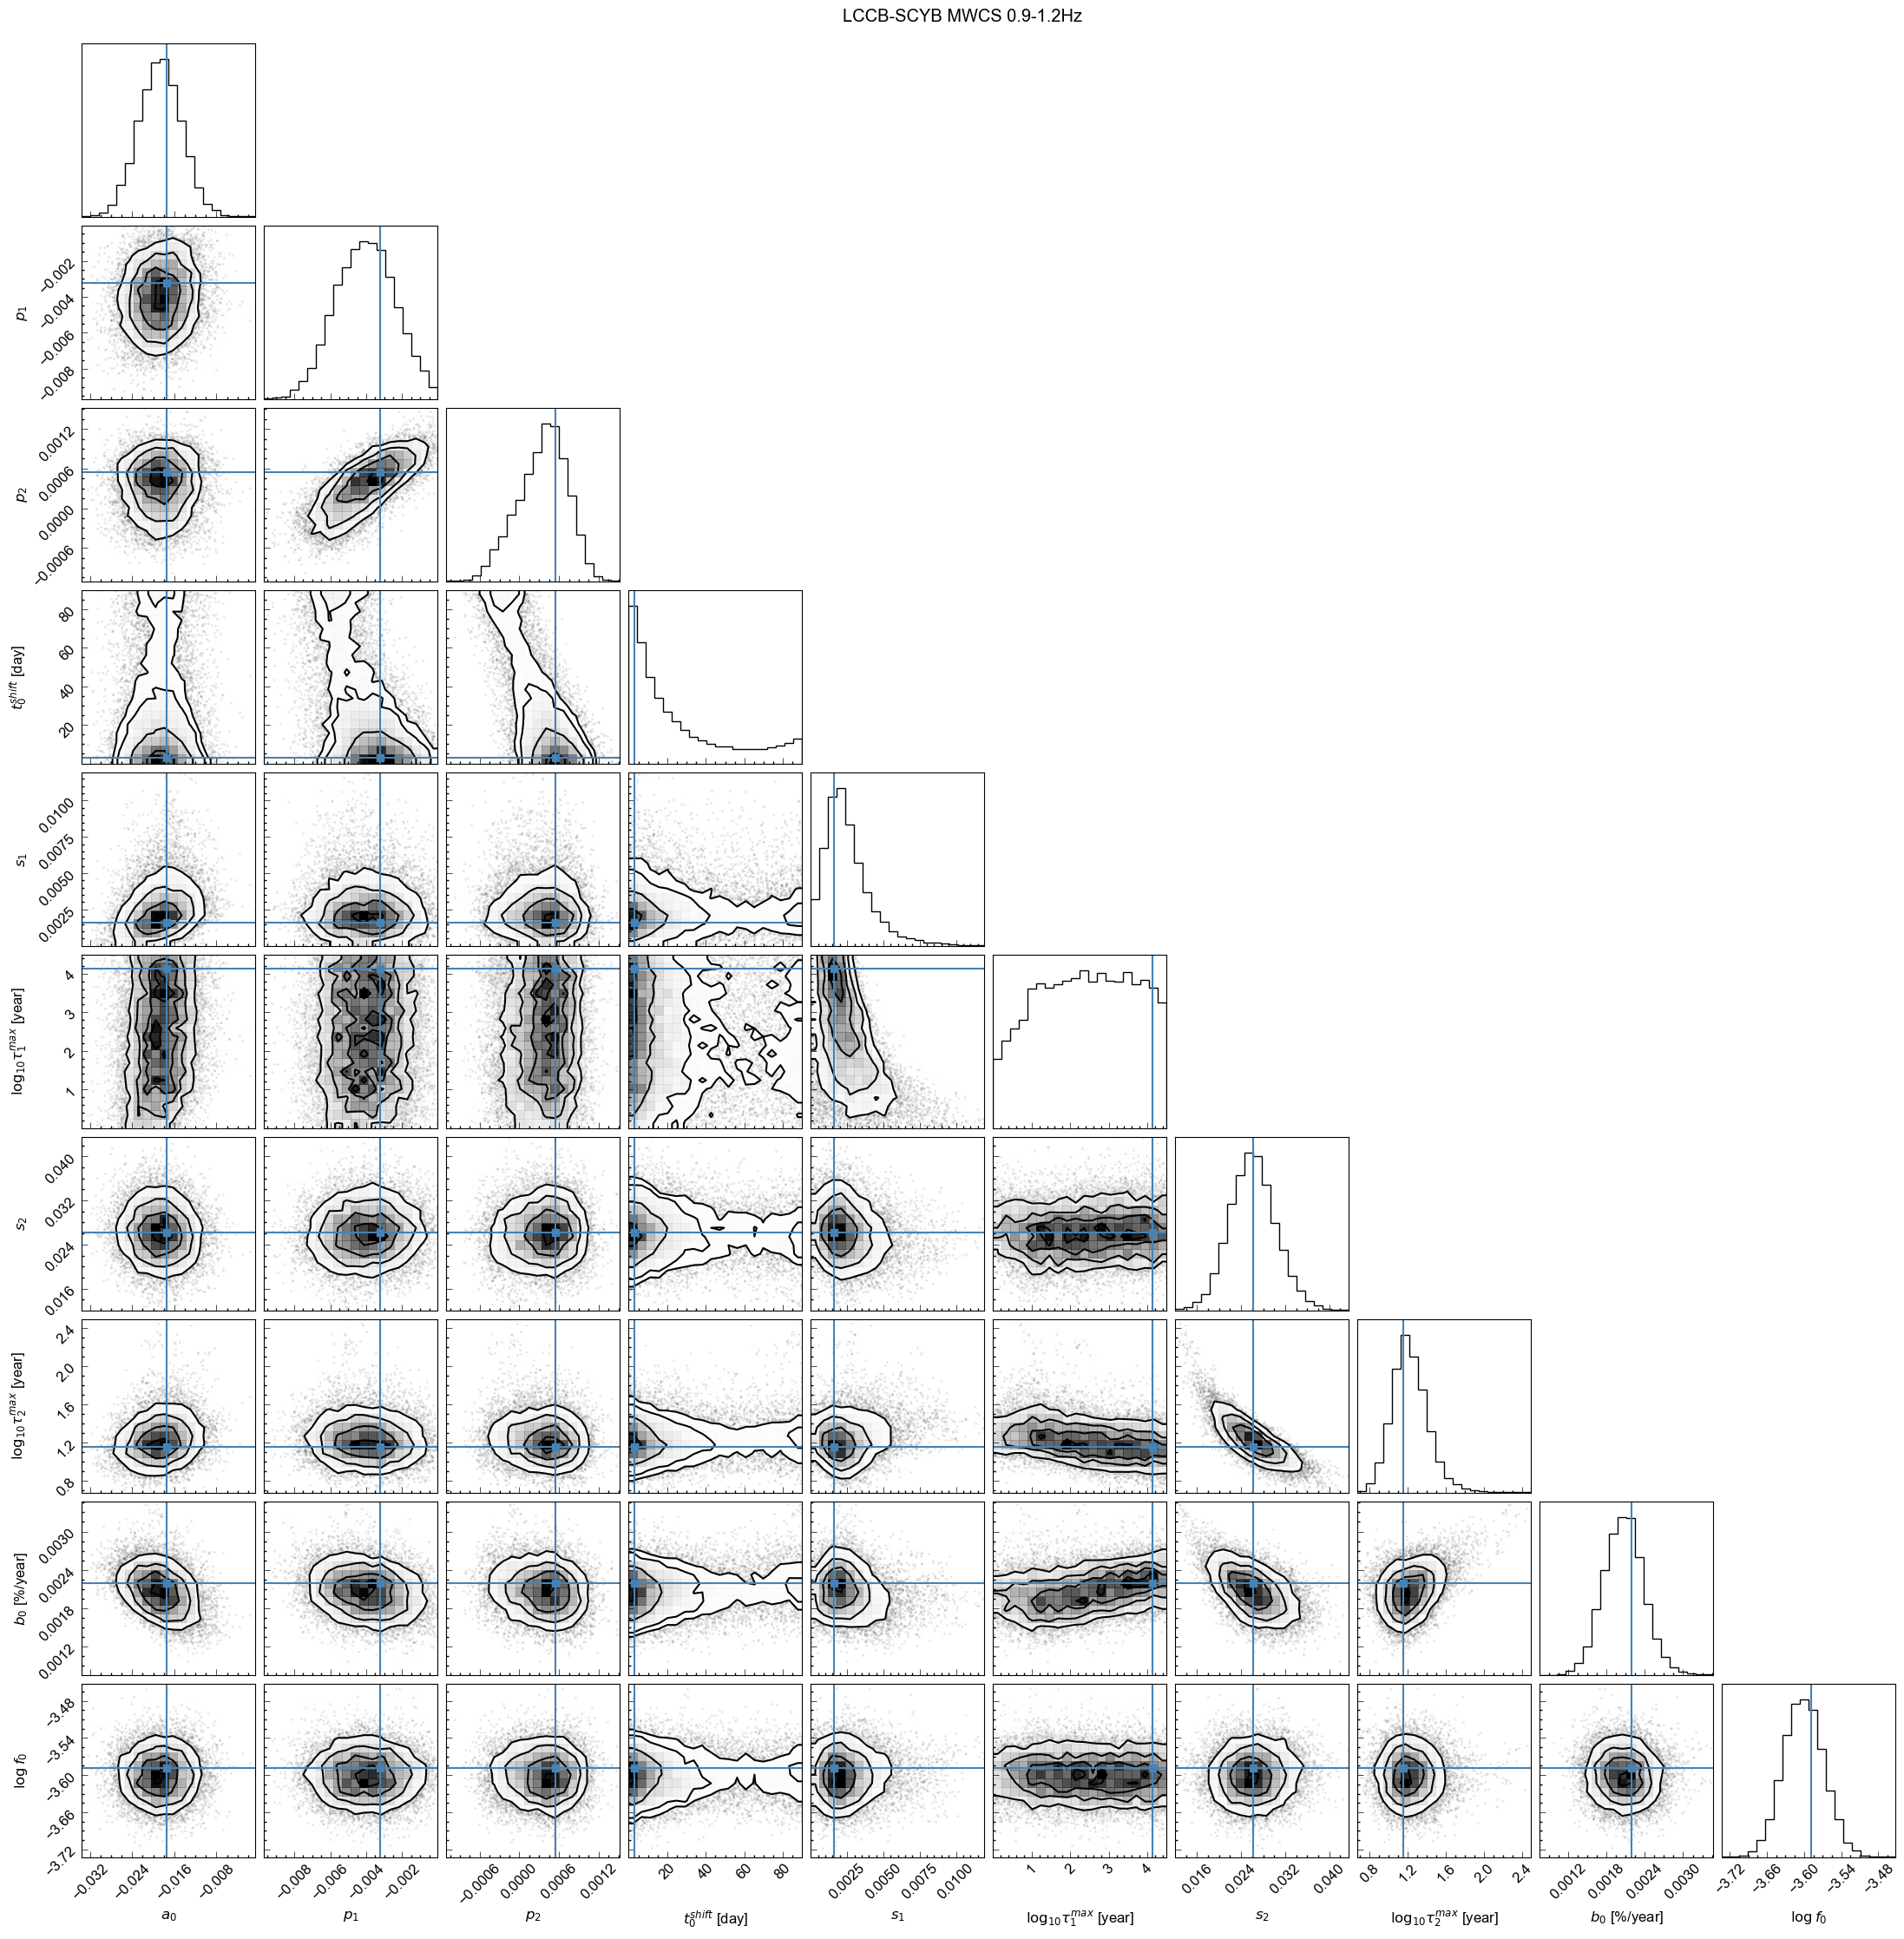

In [16]:
# Plot using corner.corner
# Reference: Foreman-Mackey (2016) https://corner.readthedocs.io/en/latest/
chains_samples_all = copy.deepcopy(sampler.get_chain(discard=mcmc_discard_nsample, thin=50, flat=True))
rescale_chain(chains_samples_all, modelcase)

fig = corner.corner(
    chains_samples_all, labels=labels, truths=maxlnprob_theta);

fig.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz', y=1)
foname = (output_imgdir+"/ex_MCMC_modelfit_cornerplot_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

In [17]:
# Read ranges and ticks from corner plot
cornerticks_x_inds =np.arange(90, 100) # axes number of lower rows for x ticks
cornerticks_y_inds =np.arange(10, 91, 10)# axes number of lower rows for y ticks
cornerranges_x = []
cornerranges_y = []
cornerticks_x = []
cornerticks_y = []

for i in cornerticks_x_inds:
    cornerranges_x.append(list(fig.axes[i].get_xlim()))
    cornerticks_x.append([np.round(x.get_unitless_position()[0], 10) for x in fig.axes[i].get_xticklabels()[:-1]])
for j in cornerticks_y_inds:
    cornerranges_y.append(list(fig.axes[j].get_ylim()))
    cornerticks_y.append([np.round(y.get_unitless_position()[1], 10) for y in fig.axes[j].get_yticklabels()[:-1]])

# print(cornerranges_x, cornerranges_y)
# print(cornerticks_x, cornerticks_y)

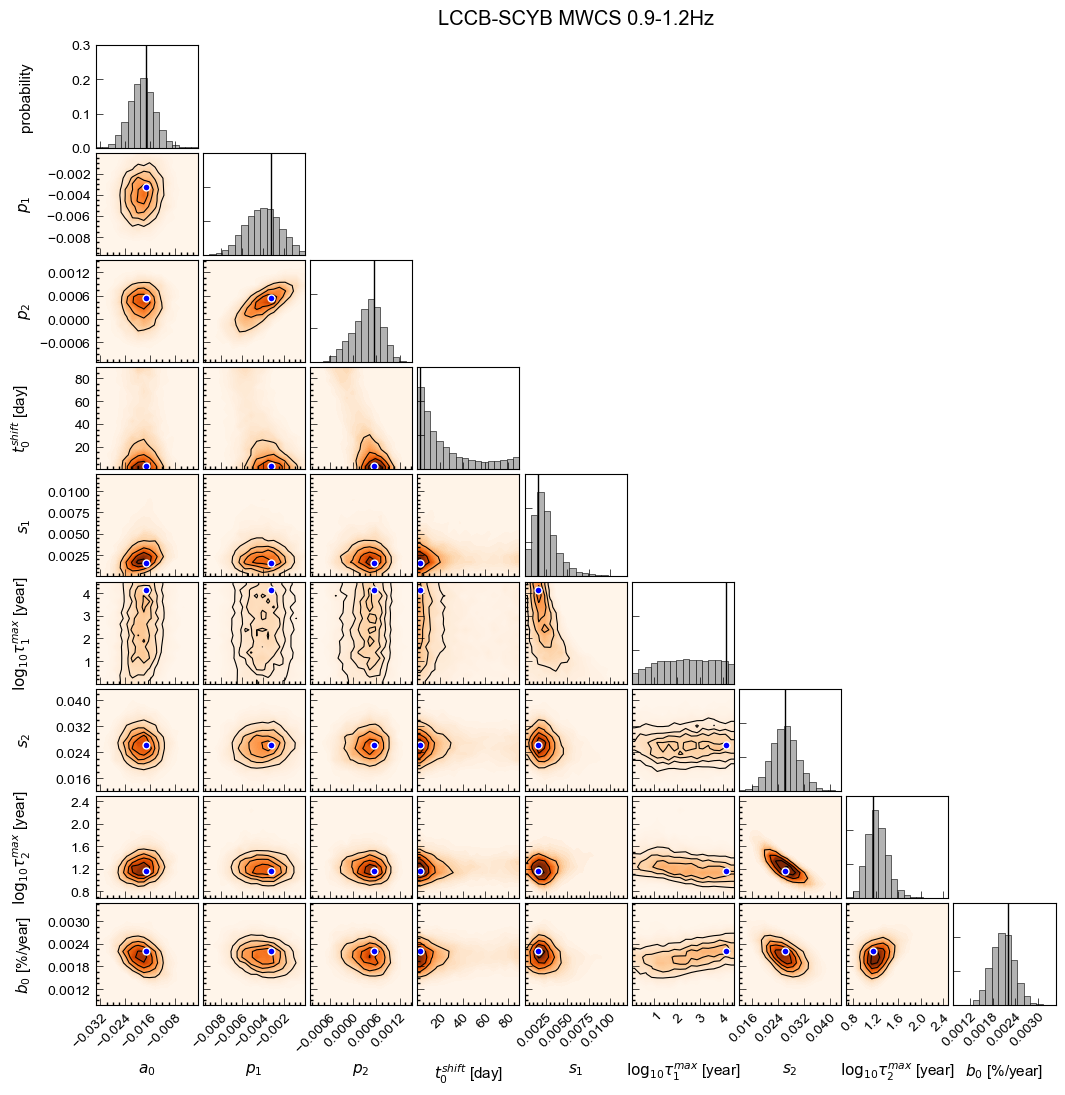

In [18]:
modelparam["nbin_hist"] = 16

# flat_samples_maxprob

fig0, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
    xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=modelparam["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4, cmap="Oranges",
    xticks=cornerticks_x, yticks=cornerticks_y, plot_truth=True,
    ylim_max=0.3, zlim_max=0.04, xranges=cornerranges_x, plot_median=False, plot_bestparam=maxlnprob_theta, labelfontsize=11, tickfontsize=10, figsize=(12, 12));

fig0.align_labels();

fig0.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz', y=0.93)
# plt.subplots_adjust(top=0.9)

foname = (output_imgdir+"/ex_MCMC_modelfit_factors_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

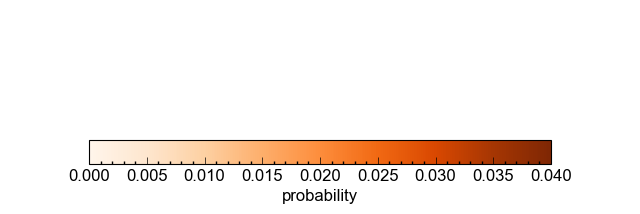

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.axis("off")
cbar=fig.colorbar(sm,orientation='horizontal',label="probability")
foname = (output_imgdir+"/ex_MCMC_scattermatrixcbar_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

## Plot MCMC iteration history

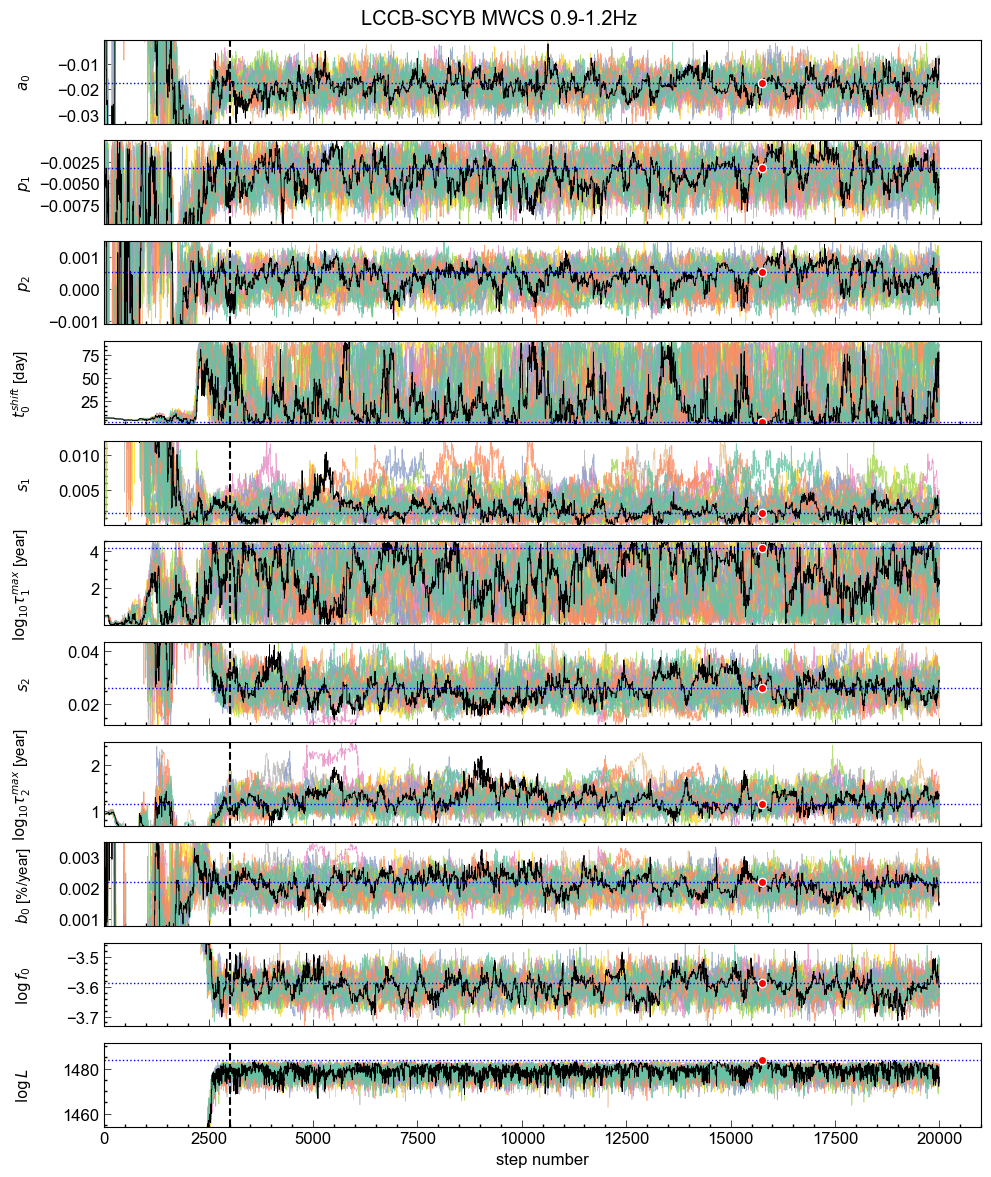

In [20]:
chain_log_prob_plot = sampler.get_log_prob(discard=0, thin=1, flat=False) # retrieve all the log prob history
max_logprob_ind = chains_lnprobmaxarg[lnprob_maxchain_id] # plot the iteration of max log prob

samples = copy.deepcopy(sampler.get_chain(discard=0, thin=1, flat=False)) # retrieve all the samples with separate chain
rescale_chain(samples, modelcase)

fig, axes = plt.subplots(sampler.ndim+1, figsize=(10, 12), sharex=True)
lw_maxprob = 0.6

labelfontsize = 10.8

# append the limit of log prob
ylim_list = copy.deepcopy(cornerranges_x)
maxprobval = chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id]
ylim_list.append([0.98*maxprobval, 1.005*maxprobval])

for i in range(sampler.ndim):
    ax = axes[i]
    
    for j in range(sampler.nwalkers):
        ax.plot(samples[:, j, i], lw=0.5, c=lc[j, :], alpha=0.8)
        
    # plot the chain with maximum log probability
    ax.plot(samples[:, lnprob_maxchain_id, i], c="k", lw=lw_maxprob) 
    
    ax.set_xlim([0, xmax])
    ax.set_ylim(ylim_list[i])
    ax.set_ylabel(labels[i], fontsize=labelfontsize)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(mcmc_discard_nsample, c="k", ls="--")
    # plot maximum likelihood parameters
    ax.axhline(maxlnprob_theta[i], c="b", ls=":", lw=1.0)
    ax.plot(max_logprob_ind+mcmc_discard_nsample, maxlnprob_theta[i], "ro", ms=6, markeredgecolor="w");

# plot maximum log probability
plot_logprob = chain_log_prob_plot[:, lnprob_maxchain_id]

ax = axes[-1]
for i in range(chain_log_prob_plot.shape[1]):
    ax.plot(chain_log_prob_plot[:, i], lw=0.5, c=lc[i, :], alpha=0.8);

ax.axvline(mcmc_discard_nsample, c="k", ls="--")
# plot the chain with maximum log probability
ax.plot(plot_logprob, c="k", lw=lw_maxprob)
ax.axhline(chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], c="b", ls=":", lw=1.0)
ax.plot(max_logprob_ind+mcmc_discard_nsample, maxprobval, "ro", ms=6, markeredgecolor="w");

ax.set_xlim([0, xmax])
ax.set_ylim(ylim_list[-1])
ax.set_ylabel("$\log{L}$", fontsize=labelfontsize)

axes[-1].set_xlabel("step number");
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

foname = (output_imgdir+"/ex_MCMC_search_chain_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))

t = fig.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz')
fig.tight_layout(rect=[0,0,1,1])
plt.subplots_adjust(hspace=0.2)
fig.align_ylabels()

plt.savefig(foname)

## Save dv/v factors with maximum likelihood model parameters

In [21]:
plotdvvfit_model = modelparam.copy()
# read observed dvv and err
dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
err_data = np.array(fi["dvv/{}/err".format(stationpair)])

plotdvvfit_model["dvv_data"] = dvv_data
plotdvvfit_model["err_data"] = err_data


In [22]:
modelparam["ndim"] = sampler.ndim

theta0 = copy.deepcopy(flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :])

# reassemble model parameters with fixed values

if modelparam["fixparam01"] == True:
    # fix the aprecip, log10tmin1 and log10tmin2
    if  modelparam["modelcase"]=="base":
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:9]), axis=None)
    elif (modelparam["modelcase"]=="wlin") or (modelparam["modelcase"]=="resheal") :
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:10]), axis=None)
else:
    theta = theta0

            
if modelparam["modelcase"] == "base":    
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF = model_base(theta, all=True, **modelparam)

elif modelparam["modelcase"] == "wlin":
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta, all=True, **modelparam)
    
elif modelparam["modelcase"] == "resheal":
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, resheal = model_resheal(theta, all=True, **modelparam)

In [23]:
# save data
plotdvvfit_model["theta"] = theta
plotdvvfit_model["model_keys"] = model_keys
plotdvvfit_model["dvvgwl"] = dvvgwl
plotdvvfit_model["dvvtemp"]= dvvtemp
plotdvvfit_model["dvvhealSS"] = dvvhealSS
plotdvvfit_model["dvvhealPF"] = dvvhealPF
plotdvvfit_model["dvv_model"] = dvvmodel

if modelparam["modelcase"] == "base":   
    plotdvvfit_model["lintrend"] = np.zeros_like(dvvmodel)
elif modelparam["modelcase"] == "wlin":
    plotdvvfit_model["lintrend"] = lintrend
elif modelparam["modelcase"] == "resheal":
    plotdvvfit_model["resheal"] = resheal

In [24]:
# Save the current state.
fodataname = (plotdvv_outdir+"/plotdvvfit_model_{}_{}_{}_{}_{}.pickle".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
with open(fodataname, "wb") as f:
    pickle.dump(plotdvvfit_model, f)


# Plot resheal MWCS 

In [25]:
modelcase = "resheal" # "wlin" or "resheal"

casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]

# split the version of MCMC case study
caseversion = os.path.basename(input_datadir).split("_")[3]

In [26]:
dvvmethod = casename.split('.csv')[0].split('_')[-1]
dvvmethod

'mwcs'

In [27]:
# read csv containing channel-weighted dvv and err
fi = h5py.File(h5_stats_list[h5_id], "r")

## Plot sampler

In [28]:
stationpairs_files = glob.glob(input_datadir+f"/*_{freqband}_{modelcase}_{dvvmethod}.pickle")
stationpairs = np.sort([os.path.basename(x).split("_")[2] for x in stationpairs_files])


In [29]:
# read sampler
finame = input_datadir+"/MCMC_sampler_{}_{}_{}_{}.pickle".format(stationpair, freqband,modelcase, dvvmethod)
with open(finame, "rb") as f:
    sampler = pickle.load(f)
    modelparam = pickle.load(f)
    
modelparam["freqband"] = freqband
modelparam["dvvmethod"] = dvvmethod

# compute line colormaps
lc = mpl.cm.Set2_r(np.linspace(0,1,sampler.nwalkers))

In [30]:
model_keys = get_keys(modelcase)

In [31]:
# create labels of data
labels = get_labels(modelcase, modelparam["fixparam01"])

In [32]:
labels

['$a_{0}$',
 '$p_1$',
 '$p_2$',
 '$t_{0}^{shift}$ [day]',
 '$s_1$',
 '$\\log_{10} \\tau_{1}^{max}$ [year]',
 '$s_2$',
 '$\\log_{10} \\tau_{2}^{max}$ [year]',
 '$c_0$ [%]',
 '$\\log{f_0}$']

In [33]:
print(f"sampler number of parameter is : {sampler.ndim}.")
print(f" {len(labels)}")

sampler number of parameter is : 10.
 10


## Evaluate the model parameters with best probability

In [34]:
# get the chains of samples separately
chains_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=False)

# get the chains of log probability
chains_lnprob =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=False)

# select the chain id with the maximum log probability among the chains
chains_lnprobmaxarg = np.argmax(chains_lnprob, axis=0)

# extract the single chain of log probability with its maximum
chains_lnprobmax = np.array([chains_lnprob[x, i] for i, x in enumerate(chains_lnprobmaxarg)])

# compare the maximum log probability with different chains and get the best chain id
lnprob_maxchain_id = np.argmax(chains_lnprobmax)

# extract the best chain of samples
flat_samples_maxprob = chains_samples[:, lnprob_maxchain_id, :]

# obtain the model parameters with the best log probability
maxlnprob_theta = copy.deepcopy(flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :])
rescale_theta(maxlnprob_theta, modelcase) # rescale t and blin

## Plot Scatter matrix

In [35]:
datainds_trim = range(len(labels[:-1]))  #[0, 1, 2] #range(len(labels[:-1])) # plot all quantities
labels_trim=[labels[x] for x in datainds_trim]

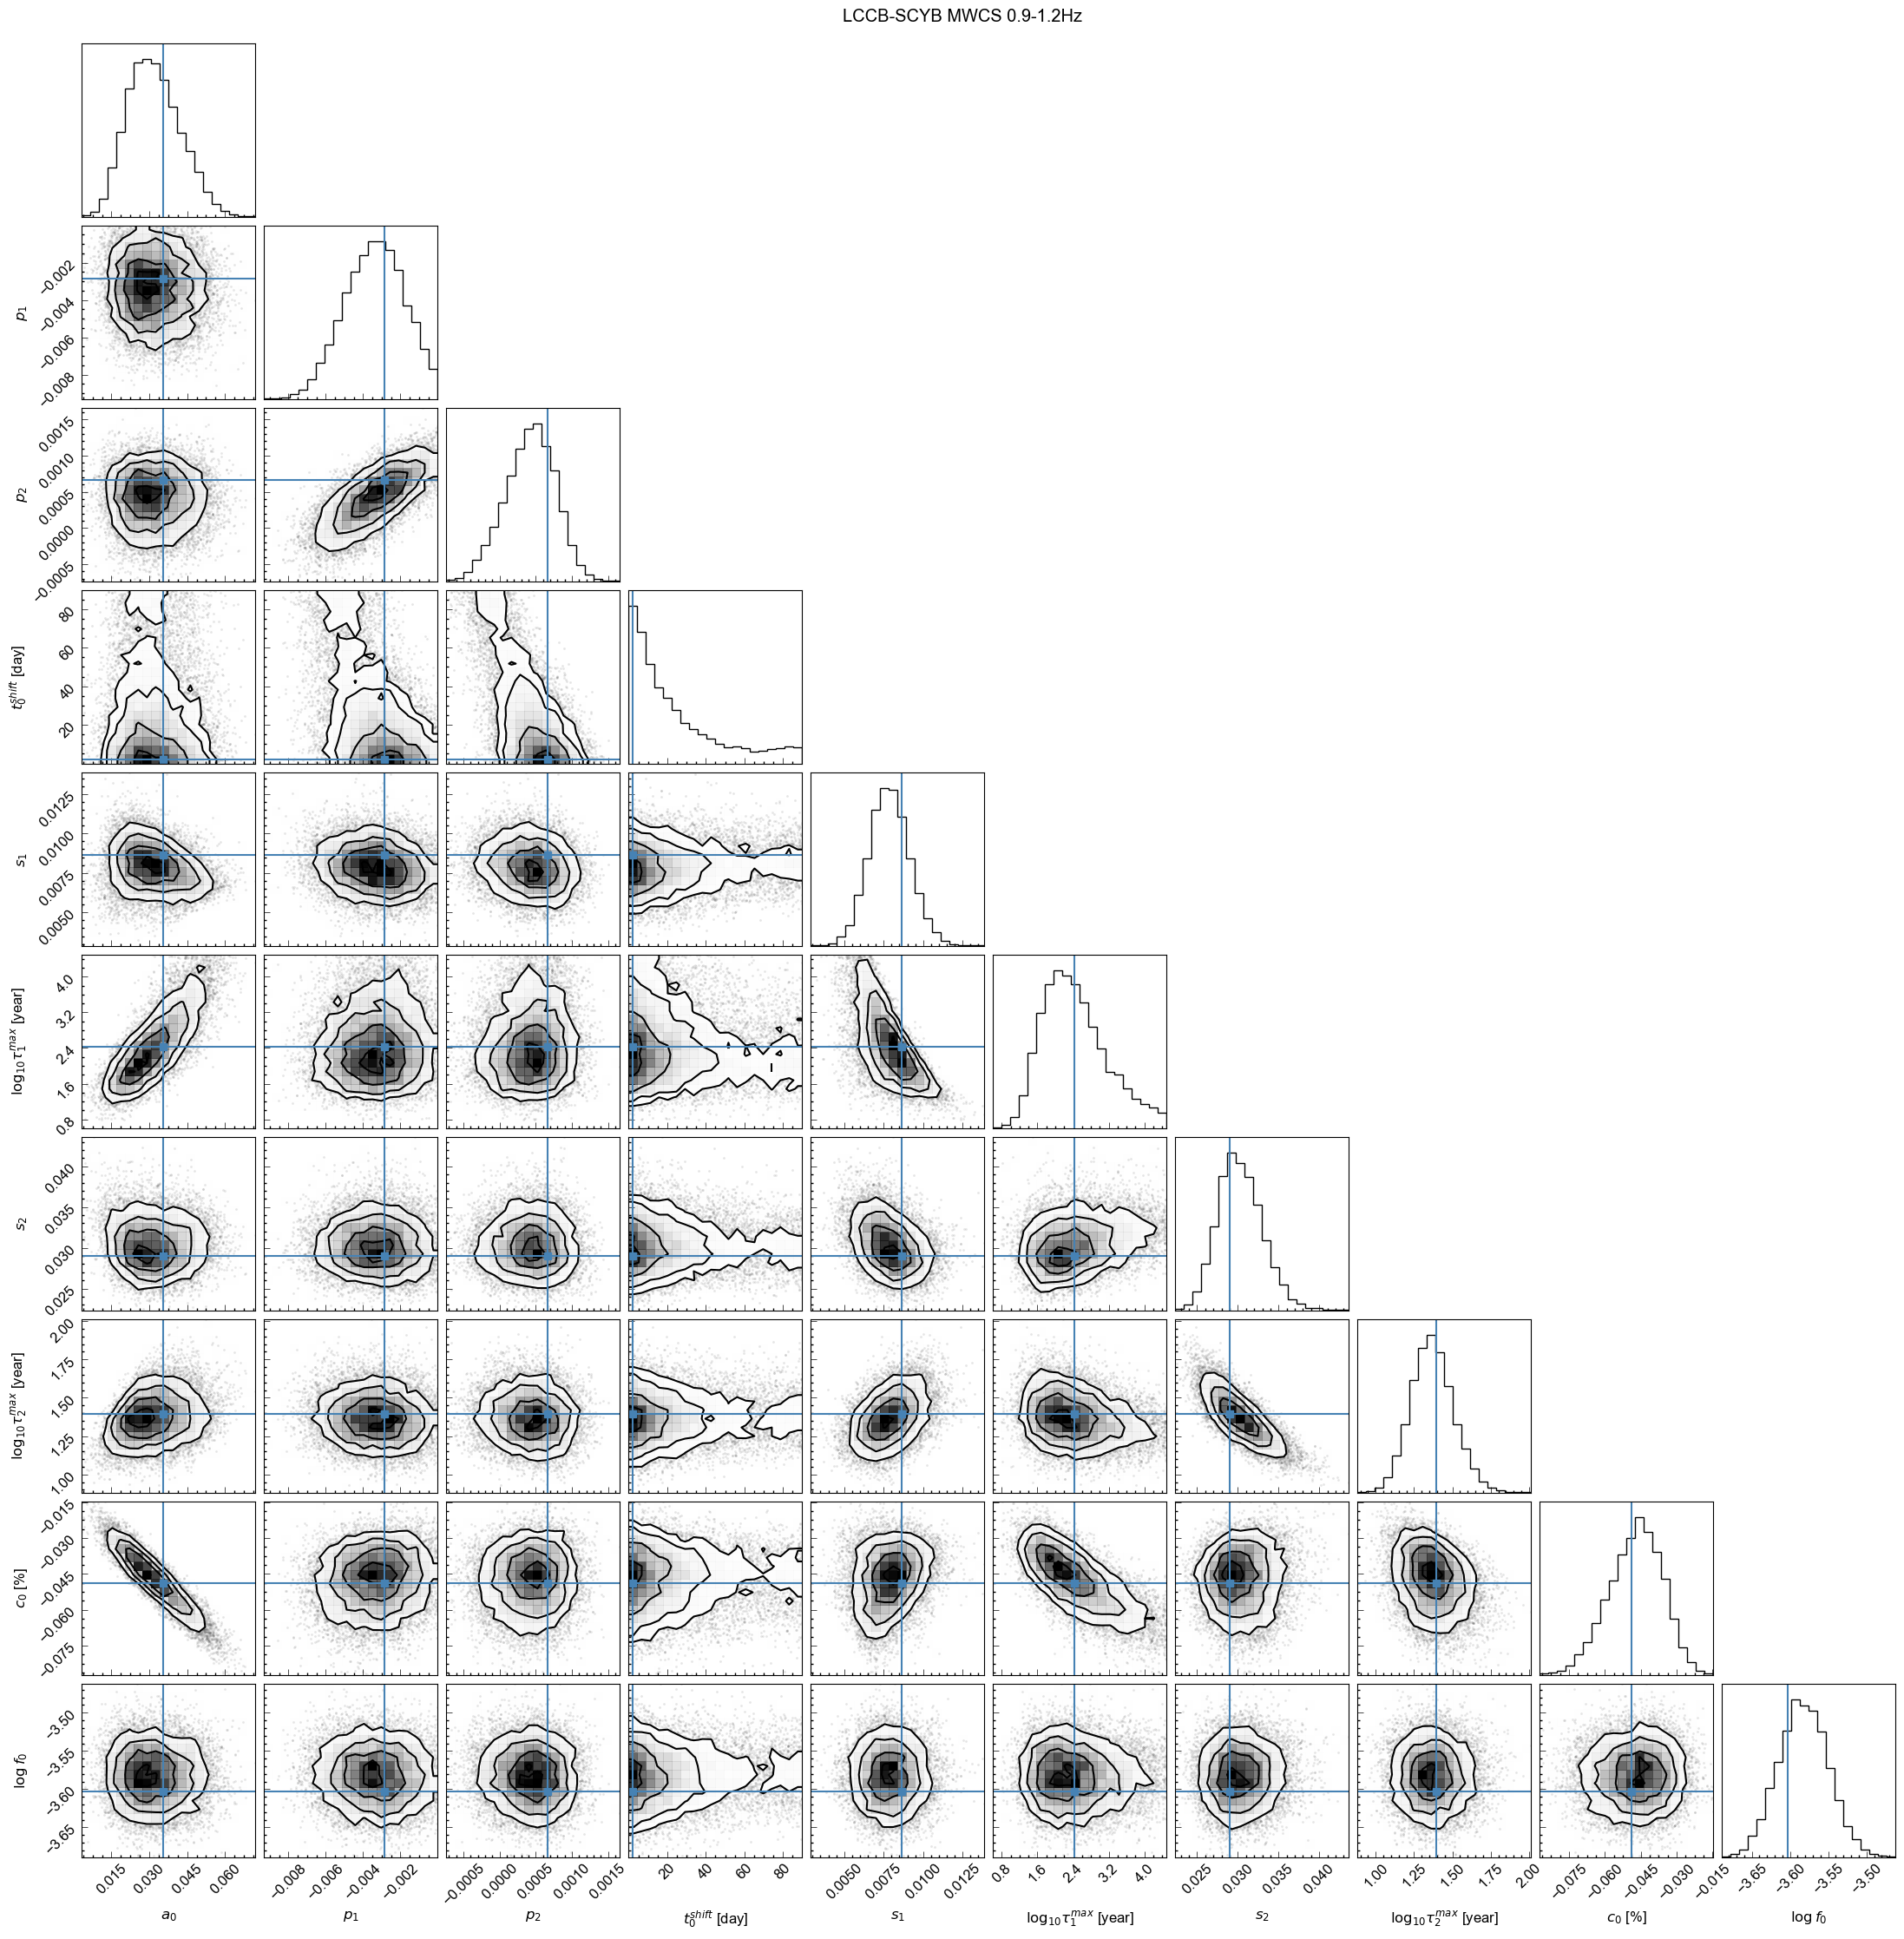

In [36]:
# Plot using corner.corner
# Reference: Foreman-Mackey (2016) https://corner.readthedocs.io/en/latest/
chains_samples_all = copy.deepcopy(sampler.get_chain(discard=mcmc_discard_nsample, thin=50, flat=True))
rescale_chain(chains_samples_all, modelcase)

fig = corner.corner(
    chains_samples_all, labels=labels, truths=maxlnprob_theta);

fig.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz', y=1)

foname = (output_imgdir+"/ex_MCMC_modelfit_cornerplot_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

In [37]:
# Read ranges and ticks from corner plot
cornerticks_x_inds =np.arange(90, 100) # axes number of lower rows for x ticks
cornerticks_y_inds =np.arange(10, 91, 10)# axes number of lower rows for y ticks
cornerranges_x = []
cornerranges_y = []
cornerticks_x = []
cornerticks_y = []

for i in cornerticks_x_inds:
    cornerranges_x.append(list(fig.axes[i].get_xlim()))
    cornerticks_x.append([np.round(x.get_unitless_position()[0], 10) for x in fig.axes[i].get_xticklabels()[:-1]])
for j in cornerticks_y_inds:
    cornerranges_y.append(list(fig.axes[j].get_ylim()))
    cornerticks_y.append([np.round(y.get_unitless_position()[1], 10) for y in fig.axes[j].get_yticklabels()[:-1]])

# print(cornerranges_x, cornerranges_y)
# print(cornerticks_x, cornerticks_y)

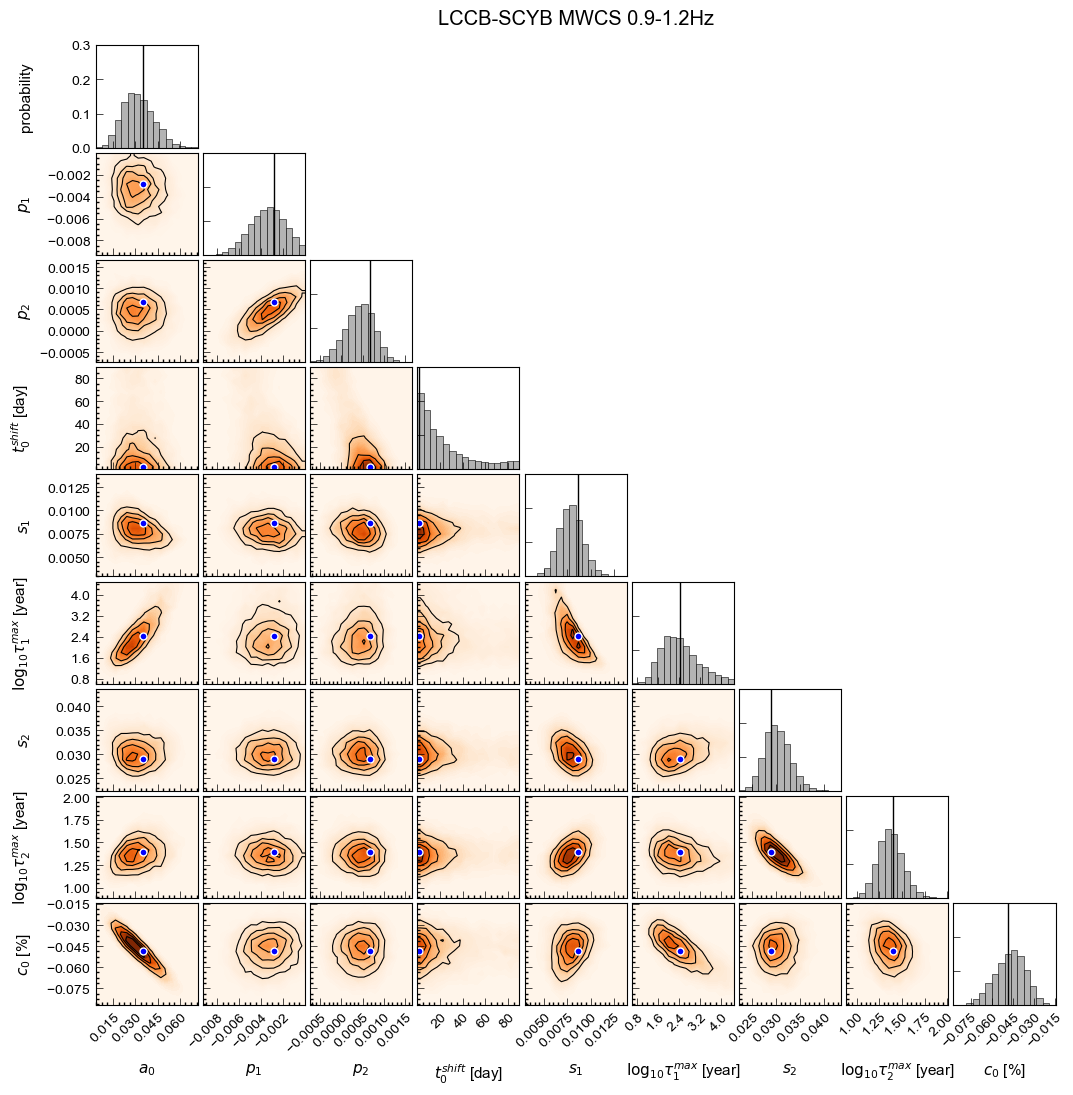

In [38]:
modelparam["nbin_hist"] = 16

# flat_samples_maxprob

fig0, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
    xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=modelparam["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4, cmap="Oranges",
    xticks=cornerticks_x, yticks=cornerticks_y, plot_truth=True,
    ylim_max=0.3, zlim_max=0.04, xranges=cornerranges_x, plot_median=False, plot_bestparam=maxlnprob_theta, labelfontsize=11, tickfontsize=10, figsize=(12, 12));

fig0.align_labels();

fig0.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz', y=0.93)

foname = (output_imgdir+"/ex_MCMC_modelfit_factors_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

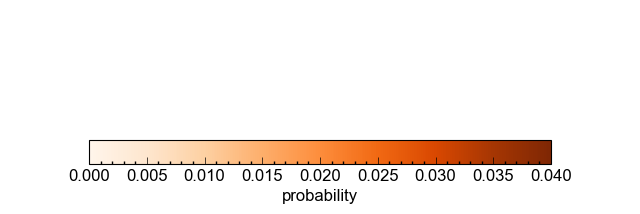

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.axis("off")
cbar=fig.colorbar(sm,orientation='horizontal',label="probability")
foname = (output_imgdir+"/ex_MCMC_scattermatrixcbar_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
plt.savefig(foname, dpi=150)

## Plot MCMC iteration history

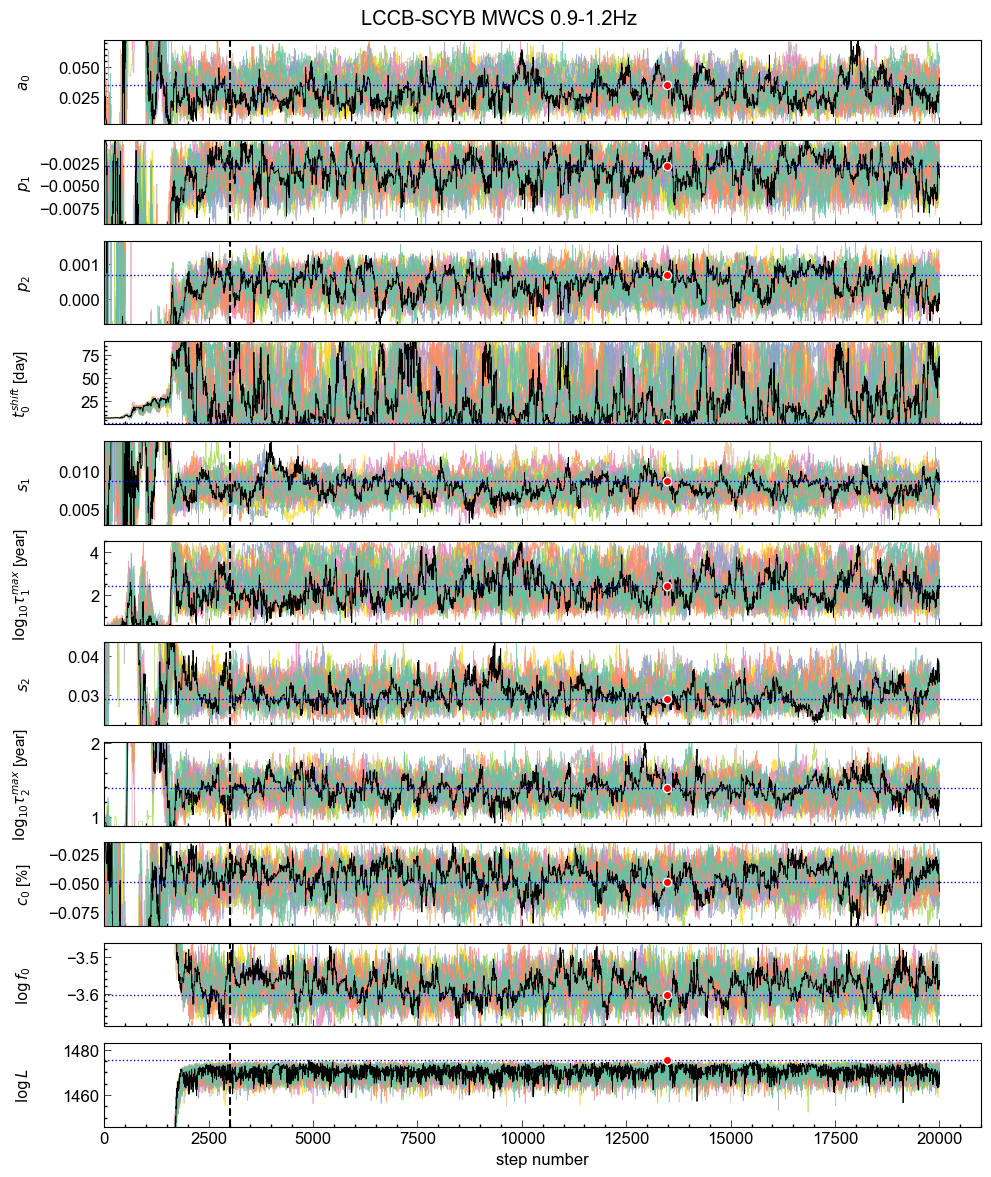

In [40]:
chain_log_prob_plot = sampler.get_log_prob(discard=0, thin=1, flat=False) # retrieve all the log prob history
max_logprob_ind = chains_lnprobmaxarg[lnprob_maxchain_id] # plot the iteration of max log prob

samples = copy.deepcopy(sampler.get_chain(discard=0, thin=1, flat=False)) # retrieve all the samples with separate chain
rescale_chain(samples, modelcase)

fig, axes = plt.subplots(sampler.ndim+1, figsize=(10, 12), sharex=True)
lw_maxprob = 0.6

labelfontsize = 10.8

# append the limit of log prob
ylim_list = copy.deepcopy(cornerranges_x)
maxprobval = chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id]
ylim_list.append([0.98*maxprobval, 1.005*maxprobval])

for i in range(sampler.ndim):
    ax = axes[i]
    
    for j in range(sampler.nwalkers):
        ax.plot(samples[:, j, i], lw=0.5, c=lc[j, :], alpha=0.8)
        
    # plot the chain with maximum log probability
    ax.plot(samples[:, lnprob_maxchain_id, i], c="k", lw=lw_maxprob) 
    
    ax.set_xlim([0, xmax])
    ax.set_ylim(ylim_list[i])
    ax.set_ylabel(labels[i], fontsize=labelfontsize)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(mcmc_discard_nsample, c="k", ls="--")
    # plot maximum likelihood parameters
    ax.axhline(maxlnprob_theta[i], c="b", ls=":", lw=1.0)
    ax.plot(max_logprob_ind+mcmc_discard_nsample, maxlnprob_theta[i], "ro", ms=6, markeredgecolor="w");

# plot maximum log probability
plot_logprob = chain_log_prob_plot[:, lnprob_maxchain_id]

ax = axes[-1]
for i in range(chain_log_prob_plot.shape[1]):
    ax.plot(chain_log_prob_plot[:, i], lw=0.5, c=lc[i, :], alpha=0.8);

ax.axvline(mcmc_discard_nsample, c="k", ls="--")
# plot the chain with maximum log probability
ax.plot(plot_logprob, c="k", lw=lw_maxprob)
ax.axhline(chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], c="b", ls=":", lw=1.0)
ax.plot(max_logprob_ind+mcmc_discard_nsample, maxprobval, "ro", ms=6, markeredgecolor="w");

ax.set_xlim([0, xmax])
ax.set_ylim(ylim_list[-1])
ax.set_ylabel("$\log{L}$", fontsize=labelfontsize)

axes[-1].set_xlabel("step number");
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

foname = (output_imgdir+"/ex_MCMC_search_chain_{}_{}_{}_{}_{}.png".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))

t = fig.suptitle(f'{sta1}-{sta2} {dvvmethod.upper()} {freqband}Hz')
fig.tight_layout(rect=[0,0,1,1])
plt.subplots_adjust(hspace=0.2)
fig.align_ylabels()

plt.savefig(foname)

## Save dv/v factors with maximum likelihood model parameters

In [41]:
plotdvvfit_model = modelparam.copy()
# read observed dvv and err
dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
err_data = np.array(fi["dvv/{}/err".format(stationpair)])

plotdvvfit_model["dvv_data"] = dvv_data
plotdvvfit_model["err_data"] = err_data


In [42]:
modelparam["ndim"] = sampler.ndim

theta0 = copy.deepcopy(flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :])

# reassemble model parameters with fixed values

if modelparam["fixparam01"] == True:
    # fix the aprecip, log10tmin1 and log10tmin2
    if  modelparam["modelcase"]=="base":
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:9]), axis=None)
    elif (modelparam["modelcase"]=="wlin") or (modelparam["modelcase"]=="resheal") :
        theta = np.concatenate((theta0[0:2], [modelparam["a_{precip}_fixed"]], theta0[2:5], [modelparam["log10tmin1_fixed"]],
                          theta0[5:7], [modelparam["log10tmin2_fixed"]], theta0[7:10]), axis=None)
else:
    theta = theta0

            
if modelparam["modelcase"] == "base":    
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF = model_base(theta, all=True, **modelparam)

elif modelparam["modelcase"] == "wlin":
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta, all=True, **modelparam)
    
elif modelparam["modelcase"] == "resheal":
    dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, resheal = model_resheal(theta, all=True, **modelparam)

In [43]:
# save data
plotdvvfit_model["theta"] = theta
plotdvvfit_model["model_keys"] = model_keys
plotdvvfit_model["dvvgwl"] = dvvgwl
plotdvvfit_model["dvvtemp"]= dvvtemp
plotdvvfit_model["dvvhealSS"] = dvvhealSS
plotdvvfit_model["dvvhealPF"] = dvvhealPF
plotdvvfit_model["dvv_model"] = dvvmodel

if modelparam["modelcase"] == "base":   
    plotdvvfit_model["lintrend"] = np.zeros_like(dvvmodel)
elif modelparam["modelcase"] == "wlin":
    plotdvvfit_model["lintrend"] = lintrend
elif modelparam["modelcase"] == "resheal":
    plotdvvfit_model["resheal"] = resheal

In [44]:
# Save the current state.
fodataname = (plotdvv_outdir+"/plotdvvfit_model_{}_{}_{}_{}_{}.pickle".format(dvvmethod, stationpair, freqband, modelparam["modelcase"], caseversion))
with open(fodataname, "wb") as f:
    pickle.dump(plotdvvfit_model, f)


In [45]:
fodataname

'../plotdvvmodel_data_resheal/plotdvvfit_model_mwcs_BP.LCCB-BP.SCYB_0.9-1.2_resheal_v2constraintdvvdrop.pickle'

In [46]:
stationpair

'BP.LCCB-BP.SCYB'

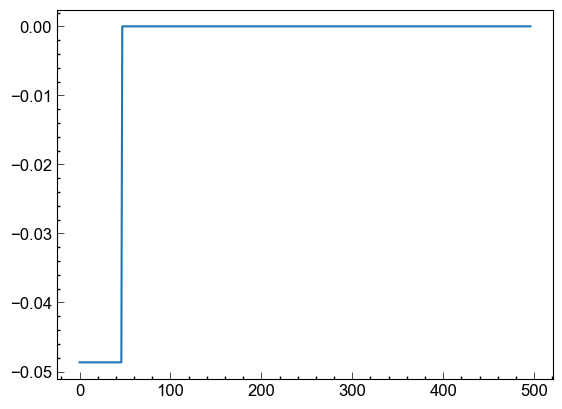

In [47]:
plt.plot(resheal)